In [45]:
# dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


In [2]:
# read csv file into df
df = pd.read_csv("../Resources/telecom_customer_churn.csv")

# Remove rows Where Customer Status = Joined
df = df[df['Customer Status'] != 'Joined']
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [3]:
# Data Cleaning:

df['Churn Category'] = df['Churn Category'].replace(np.nan,'satisfied')
df['Internet Type'] = df['Internet Type'].replace(np.nan,'No service')
df['Multiple Lines'] = df['Multiple Lines'].replace(np.nan,'No phone Service')
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].replace(np.nan,0)
df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].replace(np.nan,0)
df['Multiple Lines']=df['Multiple Lines'].replace(np.nan,'No service')
df['Internet Service']= df['Internet Service'].replace(np.nan,'No service')
df['Online Security']= df['Online Security'].replace(np.nan,'No service')
df['Online Backup']= df['Online Backup'].replace(np.nan,'No service')
df['Device Protection Plan']= df['Device Protection Plan'].replace(np.nan,'No service')
df['Premium Tech Support']= df['Premium Tech Support'].replace(np.nan,'No service')
df['Streaming TV']= df['Streaming TV'].replace(np.nan,'No service')
df['Streaming Music']= df['Streaming Music'].replace(np.nan,'No service')
df['Unlimited Data']= df['Unlimited Data'].replace(np.nan,'No service')
df['Streaming Movies']= df['Streaming Movies'].replace(np.nan,'No service')

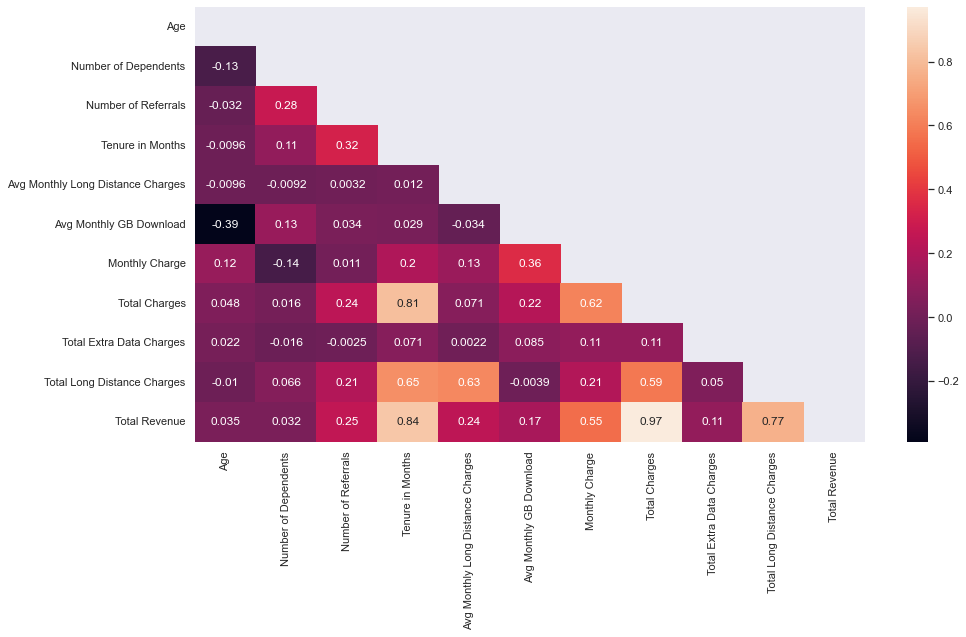

In [72]:
# Feature Selection:
    # isolate x variables for feature selection tests
data_df = df.drop(['Total Refunds', 'Paperless Billing', 'Zip Code', 
    'Latitude', 'Longitude', 'City'],axis=1).set_index('Customer ID')

# Test of multicollinearity of numeric variables
# Isolate numeric variables for correlation analysis:
numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_numeric = data_df.select_dtypes(include=numeric_types)

# Create correlation matrix for numeric features
corrmatrix = X_numeric.corr()
# sn.set(rc = {'figure.figsize':(15,8)})
mask = np.triu(np.ones_like(corrmatrix, dtype=bool))
sn.heatmap(corrmatrix, mask=mask, annot=True)
plt.show()

In [12]:
# Function for calculating Variable Inflation Factors on numeric variables
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['Variable Inflation Factors'] = [variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])] 
    return(vif)

,variables,Variable Inflation Factors
10,Total Revenue,283071.777638
7,Total Charges,168131.523910
9,Total Long Distance Charges,20778.931625
6,Monthly Charge,14.565743
3,Tenure in Months,12.721578
8,Total Extra Data Charges,11.927896
4,Avg Monthly Long Distance Charges,8.288615
0,Age,7.391060
5,Avg Monthly GB Download,2.791548
2,Number of Referrals,1.731428


In [24]:
# Compare vif before and after highly correlated features are removed
vif_all_num_columns = calculate_vif(X_numeric).sort_values('Variable Inflation Factors', ascending=False)
print(f'First Test (All Numeric Columns):\n {vif_all_num_columns}')

# Remove highly correlated features:
X_num_selection = X_numeric.drop(['Total Long Distance Charges', 'Total Charges', 'Monthly Charge'], axis=1)
vif_selection = calculate_vif(X_num_selection).sort_values('Variable Inflation Factors', ascending=False)
print(f'Second Test (Selected Columns):\n {vif_selection}')

First Test (All Numeric Columns):
                             variables  Variable Inflation Factors
10                      Total Revenue               283071.777638
7                       Total Charges               168131.523910
9         Total Long Distance Charges                20778.931625
6                      Monthly Charge                   14.565743
3                    Tenure in Months                   12.721578
8            Total Extra Data Charges                   11.927896
4   Avg Monthly Long Distance Charges                    8.288615
0                                 Age                    7.391060
5             Avg Monthly GB Download                    2.791548
2                 Number of Referrals                    1.731428
1                Number of Dependents                    1.421003
Second Test (Selected Columns):
                            variables  Variable Inflation Factors
3                   Tenure in Months                   10.771938
7         

In [55]:
# Encode Categorical Data:
def encode_data(df):
    df = LabelEncoder().fit_transform(df)
    return df
categorical_data = data_df.select_dtypes(include='object')
encoded_data = categorical_data.apply(lambda x: encode_data(x))

# Convert y to 1D array
y = np.ravel(encoded_data[['Customer Status']])

# isolate categorical encoded features
features_encoded = encoded_data.drop(['Customer Status', 'Churn Category', 'Churn Reason'], axis=1)

In [79]:
# Classification Feature Selection of the numerical variables against the target (categorical variable)

# ANOVA f-test for feature selection
    # ANOVA: analysis of variance. A test for determining whether the means from two or more samples of data come from the
        # same distribution
    # ANOVA is used when one variable is numeric and one is categorical
    # The methods based on F-test estimate the degree of linear dependency between two random variables
    # The result tells us which features are independent to the target variable

# define feature selection:
    # Select features according to the k highest scores
    # k=5 instructs the variable function to select the (4 best) features that are the most linearly dependent with the target
    # f_classif function computes the ANOVA f-score
fs_num = SelectKBest(score_func=f_classif, k=4)

# apply feature selection:
fs_num.fit(X_num_selection, y)
selected_features_num = fs_num.transform(X_num_selection)

# tabulate features and view dataframe:
numerical_features_df = pd.DataFrame({'numerical_features': X_num_selection.columns, 
    'KBest_to_keep': fs_num.get_support(), 'f-score': fs_num.scores_})
numerical_features_df

# isolate best numerical features
best_num_features = X_numeric[['Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Total Revenue']]
numerical_features_df



,numerical_features,KBest_to_keep,f-score
0,Age,False,82.431541
1,Number of Dependents,True,376.502505
2,Number of Referrals,True,710.948463
3,Tenure in Months,True,1526.535347
4,Avg Monthly Long Distance Charges,False,0.291017
5,Avg Monthly GB Download,False,10.588472
6,Total Extra Data Charges,False,0.000442
7,Total Revenue,True,554.405346


In [78]:
# Classification Feature Selection of the categorical variables against the target (categorical variable)
fs_cat = SelectKBest(score_func=chi2, k=4)

# apply feature selection:
fs_cat.fit(features_encoded, y)
selected_features_num = fs_cat.transform(features_encoded)

# tabulate features and view dataframe:
categorical_features_df = pd.DataFrame({'categorical_features': features_encoded.columns, 
    'KBest_to_keep': fs_cat.get_support(), 'f-score': fs_cat.scores_})
categorical_features_df

# isolate best categorical features
best_cat_features = features_encoded[['Offer', 'Online Security', 'Premium Tech Support', 'Contract']]
categorical_features_df



,categorical_features,KBest_to_keep,f-score
0,Gender,False,0.133089
1,Married,False,109.869893
2,Offer,True,309.680506
3,Phone Service,False,0.132963
4,Multiple Lines,False,0.567943
5,Internet Service,False,67.509142
6,Internet Type,False,6.848586
7,Online Security,True,591.737438
8,Online Backup,False,262.006146
9,Device Protection Plan,False,229.244382


In [67]:
# Collate best features:
merged_X_df = pd.merge(best_num_features, best_cat_features, left_index=True, right_index=True)
X = merged_X_df.reset_index(drop=True)

# Split data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# Normalize the features of our dataset using MinMaxScaler
# fit scaler on training data
X_n_fit = MinMaxScaler().fit(X_train)

# Step 2: Transform the training data
X_n_train = X_n_fit.transform(X_train)

# Step 3: Transform the testing data
X_n_test = X_n_fit.transform(X_test)


In [80]:
X.columns

Index(['Number of Dependents', 'Number of Referrals', 'Tenure in Months',
       'Total Revenue', 'Offer', 'Online Security', 'Premium Tech Support',
       'Contract'],
      dtype='object')

In [83]:

# Step 3: Transform the testing data
X_n_test = X_n_fit.transform(X_test)
# Define the model:
knn_model = KNeighborsClassifier()

# (tune) the model with GridSearch and Stratify kfold:

# key parameters:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# store parameters in parameter object:
param_grid_knn = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

cv_knn = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid search estimator:
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, n_jobs=-1, cv=cv_knn, scoring='accuracy', error_score=0)

# fit the grid search using the grid search estimator with the train data:
# This will take the KNN model and try each combination of parameters
grid_result_knn = grid_search_knn.fit(X_n_train, y_train)

# summarize results
print("Test Accuracy: %f, Grid Result: %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means_knn = grid_result_knn.cv_results_['mean_test_score']
stds_knn = grid_result_knn.cv_results_['std_test_score']
params_knn = grid_result_knn.cv_results_['params']
for mean, stdev, param in zip(means_knn, stds_knn, params_knn):
    print("%f (%f) with: %r" % (mean, stdev, param))

Test Accuracy: 0.839181, Grid Result: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}
0.808006 (0.019319) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.808006 (0.019319) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.826090 (0.018501) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.817806 (0.017325) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.833300 (0.016546) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.825837 (0.017558) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.836020 (0.015614) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.829380 (0.018492) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.837158 (0.014040) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.829253 (0.016270) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'dis

              precision    recall  f1-score   support

      Stayed       0.74      0.70      0.72       374
     Churned       0.88      0.90      0.89       944

    accuracy                           0.85      1318
   macro avg       0.81      0.80      0.81      1318
weighted avg       0.84      0.85      0.84      1318



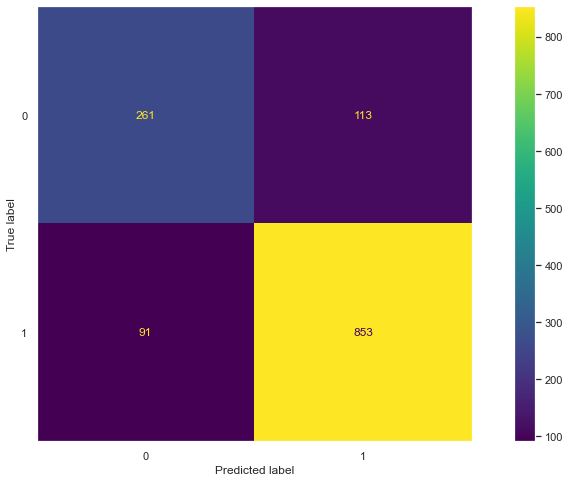

In [77]:
# Using the optimal parameters obtained by our gridsearch we can re-define the model:
knn_model_tuned = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 19, weights = 'uniform')

# pass in train data to .fit() to train our knn model: 
knn_model_tuned.fit(X_n_train, y_train)

# How accurate is the model in predicting the target class?
    # use the .predict() method and store the predicted values for the input values in the X_test_lr set
pred_class_knn = knn_model_tuned.predict(X_n_test)

# Plot Confusion Matrix:
plot_confusion_matrix(grid_search_knn, X_n_test, y_test, values_format='d')
plt.grid(False)

# Print Classification Report:
target_names = ['Stayed', 'Churned']
print(classification_report(y_test, pred_class_knn,
                            target_names=target_names)) 